In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision.transforms as v1
from torchvision.io import decode_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
import sys
sys.path += ["../transforms"]
from helpers import plot
ASSETS_PATH = Path('../assets')

Most transforms support torchscript. For composing transforms, we use
:class:`torch.nn.Sequential` instead of
:class:`~torchvision.transforms.v2.Compose`:



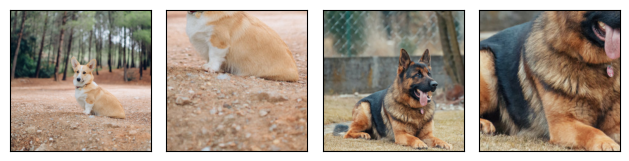

In [ ]:
dog1 = decode_image('/home/skr3178/lerobot/Resnet/dog1.jpg')
dog2 = decode_image('/home/skr3178/lerobot/Resnet/dog2.jpg')

transforms = torch.nn.Sequential(
    v1.RandomCrop(224),
    v1.RandomHorizontalFlip(p=0.3),
)

scripted_transforms = torch.jit.script(transforms)

plot([dog1, scripted_transforms(dog1), dog2, scripted_transforms(dog2)])

In [15]:
dog1

tensor([[[ 50,  51,  48,  ...,  98,  96,  98],
         [ 43,  46,  45,  ...,  95,  95,  97],
         [ 41,  45,  46,  ...,  89,  92,  95],
         ...,
         [139, 140, 131,  ..., 192, 193, 191],
         [114, 117, 113,  ..., 198, 197, 193],
         [111, 105, 101,  ..., 199, 197, 190]],

        [[ 64,  62,  59,  ..., 110, 108, 110],
         [ 57,  57,  56,  ..., 107, 107, 109],
         [ 55,  56,  56,  ..., 103, 106, 109],
         ...,
         [109, 112, 105,  ..., 173, 174, 172],
         [ 83,  88,  87,  ..., 179, 178, 174],
         [ 79,  76,  75,  ..., 180, 178, 171]],

        [[ 64,  64,  61,  ..., 100,  98, 100],
         [ 57,  59,  58,  ...,  95,  95,  97],
         [ 56,  58,  57,  ...,  88,  91,  94],
         ...,
         [ 85,  91,  88,  ..., 156, 159, 157],
         [ 63,  72,  72,  ..., 164, 161, 157],
         [ 64,  62,  62,  ..., 165, 161, 154]]], dtype=torch.uint8)

In [16]:
from torchvision.models import resnet18, ResNet18_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False).eval()
        self.transforms = weights.transforms(antialias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

In [17]:
ResNet18_Weights.DEFAULT.meta

{'min_size': (1, 1),
 'categories': ['tench',
  'goldfish',
  'great white shark',
  'tiger shark',
  'hammerhead',
  'electric ray',
  'stingray',
  'cock',
  'hen',
  'ostrich',
  'brambling',
  'goldfinch',
  'house finch',
  'junco',
  'indigo bunting',
  'robin',
  'bulbul',
  'jay',
  'magpie',
  'chickadee',
  'water ouzel',
  'kite',
  'bald eagle',
  'vulture',
  'great grey owl',
  'European fire salamander',
  'common newt',
  'eft',
  'spotted salamander',
  'axolotl',
  'bullfrog',
  'tree frog',
  'tailed frog',
  'loggerhead',
  'leatherback turtle',
  'mud turtle',
  'terrapin',
  'box turtle',
  'banded gecko',
  'common iguana',
  'American chameleon',
  'whiptail',
  'agama',
  'frilled lizard',
  'alligator lizard',
  'Gila monster',
  'green lizard',
  'African chameleon',
  'Komodo dragon',
  'African crocodile',
  'American alligator',
  'triceratops',
  'thunder snake',
  'ringneck snake',
  'hognose snake',
  'green snake',
  'king snake',
  'garter snake',
  '

In [ ]:
import torch

model_path = "/home/skr3178/lerobot/Resnet/resnet18-f37072fd.pth"  # Replace with the actual path to your .pth file
model_state_dict = torch.load(model_path)

In [20]:
model_state_dict

OrderedDict([('conv1.weight',
              Parameter containing:
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-

Now, let's define scripted and non-scripted instances of ``Predictor`` and
apply it on multiple tensor images of the same size



In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([dog1, dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

We can verify that the prediction of the scripted and non-scripted models are
the same:



In [ ]:
import json

with open('/home/skr3178/lerobot/Resnet/imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Prediction for Dog 1: ['n02113023', 'Pembroke']
Prediction for Dog 2: ['n02106662', 'German_shepherd']


Since the model is scripted, it can be easily dumped on disk and re-used

